# Nepali Sign Language Detection

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Input
import random
import collections
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay

2025-08-06 00:50:53.095637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754441453.324170      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754441453.392745      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import os

# for root, dirs, files in os.walk("/kaggle/input"):
#     print(root)
#     for name in dirs:
#         print( name)
#     for name in files:
#         print(name)
#     print("-" * 50)


In [3]:
nepali_map = {
    0: 'क', 1: 'ख', 2: 'ग', 3: 'घ', 4: 'ङ', 5: 'च', 6: 'छ', 7: 'ज', 8: 'झ', 9: 'ञ',
    10: 'ट', 11: 'ठ', 12: 'ड', 13: 'ढ', 14: 'ण', 15: 'त', 16: 'थ', 17: 'द', 18: 'ध', 19: 'न',
    20: 'प', 21: 'फ', 22: 'ब', 23: 'भ', 24: 'म', 25: 'य', 26: 'र', 27: 'ल', 28: 'व',
    29: 'श', 30: 'ष', 31: 'स', 32: 'ह', 33: 'क्ष', 34: 'त्र', 35: 'ज्ञ'
}


In [4]:
IMG_SIZE = 96
plain_path = "/kaggle/input/nepali-sign-language-character-dataset/NSL/Plain Background"
random_path = "/kaggle/input/nepali-sign-language-character-dataset/NSL/Random Background"


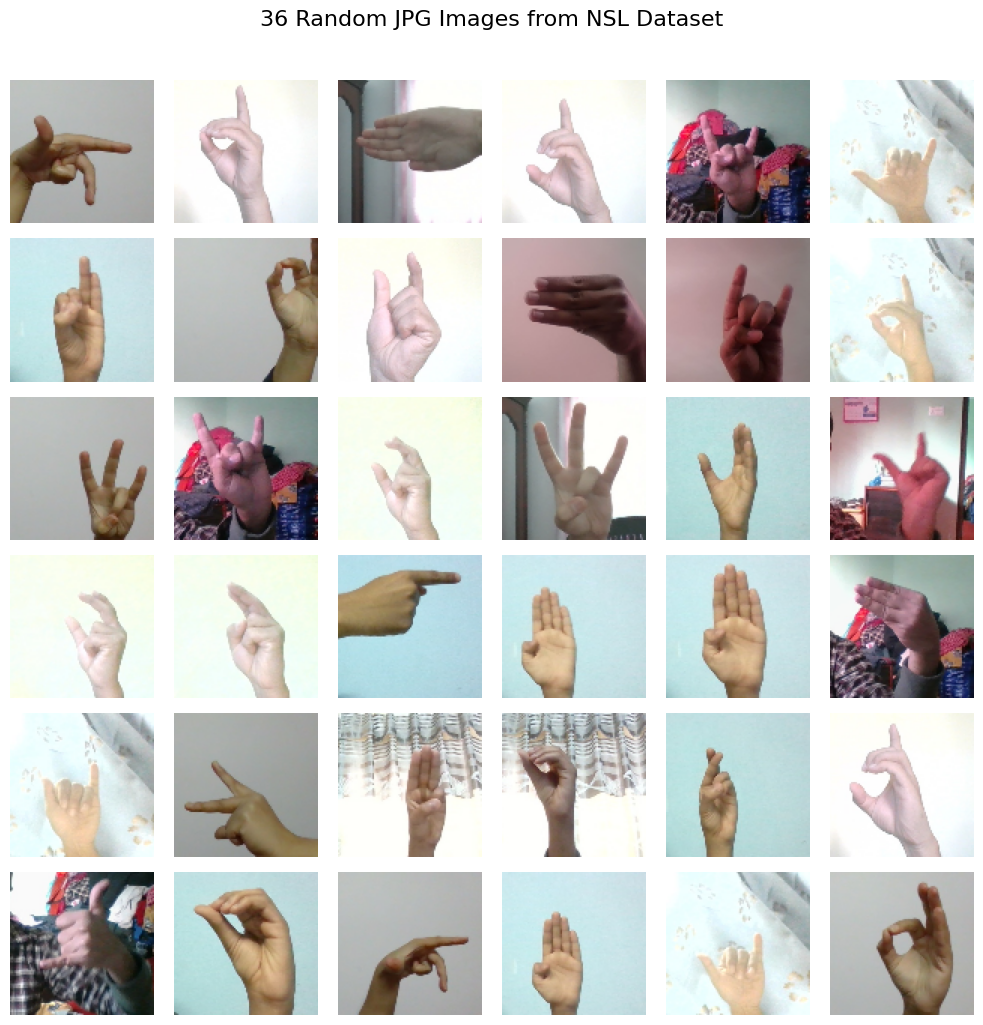

In [5]:
all_image_paths = []

for root, dirs, files in os.walk(plain_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_image_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(random_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_image_paths.append(os.path.join(root, file))

# Randomly choose 36 images
sampled_images = random.sample(all_image_paths, 36)

# Plotting
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sampled_images):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("36 Random JPG Images from NSL Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

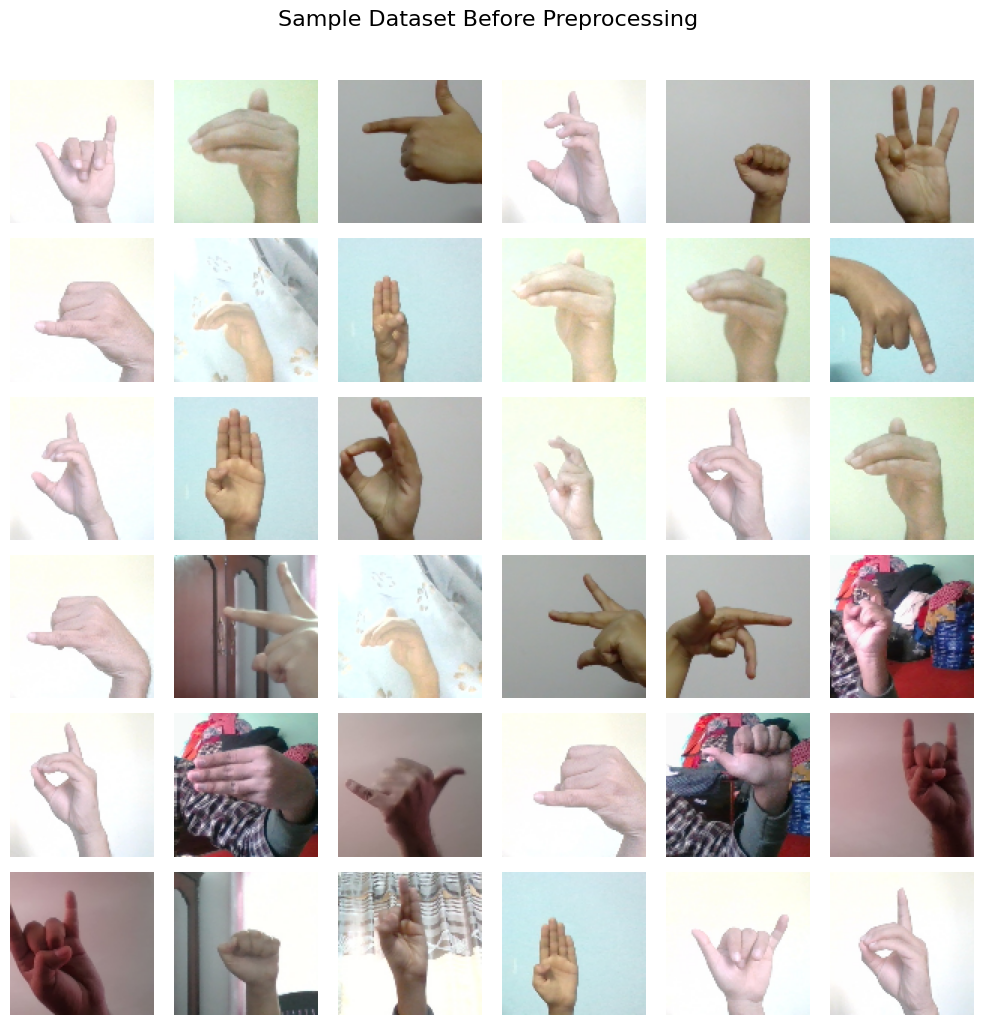

In [6]:
all_image_paths = []

for root, dirs, files in os.walk(plain_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_image_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(random_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_image_paths.append(os.path.join(root, file))

# Randomly choose 36 images
sampled_images = random.sample(all_image_paths, 36)

# Plotting
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sampled_images):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dataset Before Preprocessing ", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
X, y = [], []

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.fastNlMeansDenoising(img, None, 30, 7, 21)

    img = cv2.equalizeHist(img)

    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

    coords = cv2.findNonZero(img)
    if coords is not None:
        x, y_, w, h = cv2.boundingRect(coords)
        img = img[y_:y_+h, x:x+w]

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = img / 255.0

    return img



def load_images_from_folder(base_path, label):
    folder_path = os.path.join(base_path, str(label))
    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label)
            

In [8]:
for label in range(36):
    load_images_from_folder(plain_path, label)
    load_images_from_folder(random_path, label)

In [9]:
nepali_map_roman = {
    0: 'Ka', 1: 'Kha', 2: 'Ga', 3: 'Gha', 4: 'Nga',
    5: 'Cha', 6: 'Chha', 7: 'Ja', 8: 'Jha', 9: 'Nya',
    10: 'Ta', 11: 'Tha', 12: 'Da', 13: 'Dha', 14: 'Na',
    15: 'Ta', 16: 'Tha', 17: 'Da', 18: 'Dha', 19: 'Na',
    20: 'Pa', 21: 'Pha', 22: 'Ba', 23: 'Bha', 24: 'Ma',
    25: 'Ya', 26: 'Ra', 27: 'La', 28: 'Wa', 29: 'Sha',
    30: 'Sha', 31: 'Sa', 32: 'Ha', 33: 'Ksha', 34: 'Tra', 35: 'Gya'
}

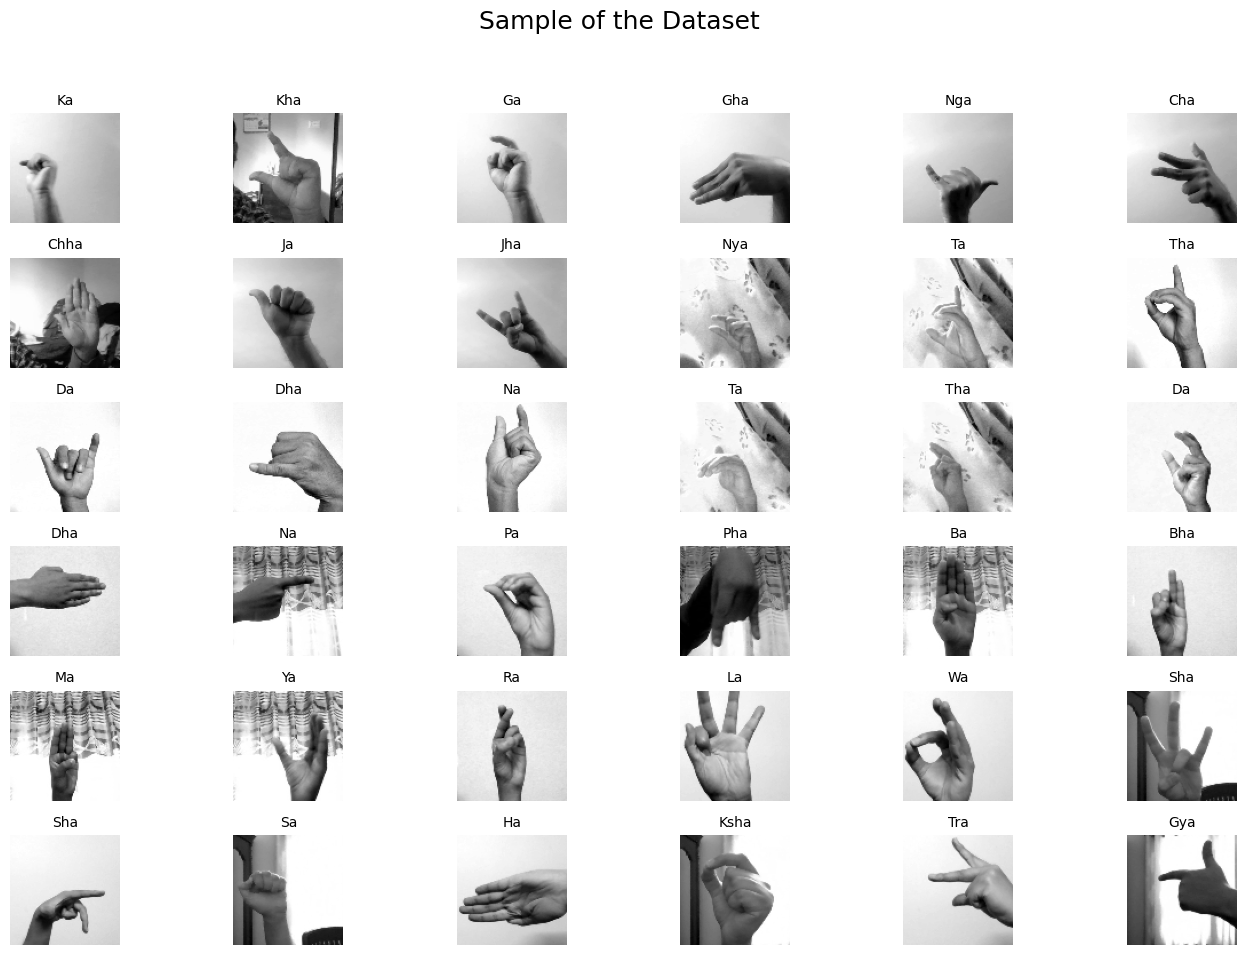

In [10]:
rows, cols = 6, 6
plt.figure(figsize=(14, 10))
sampled_indices = []

for class_idx in range(36):
    indices = [i for i, lbl in enumerate(y) if lbl == class_idx]
    if len(indices) > 0:
        sampled_indices.append(random.choice(indices))

for i, idx in enumerate(sampled_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx], cmap='gray')
    label_index = y[idx]
    label_roman = nepali_map_roman[label_index]
    plt.title(f"{label_roman}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample of the Dataset ", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
y = to_categorical(y, num_classes=36)

In [12]:
print("Basic Dataset Info:")
print(f"Total images: {len(X)}")
print(f"Image shape (H×W×C): {X[0].shape}")
print(f"Total classes: {y.shape[1]}")

Basic Dataset Info:
Total images: 54000
Image shape (H×W×C): (96, 96, 1)
Total classes: 36


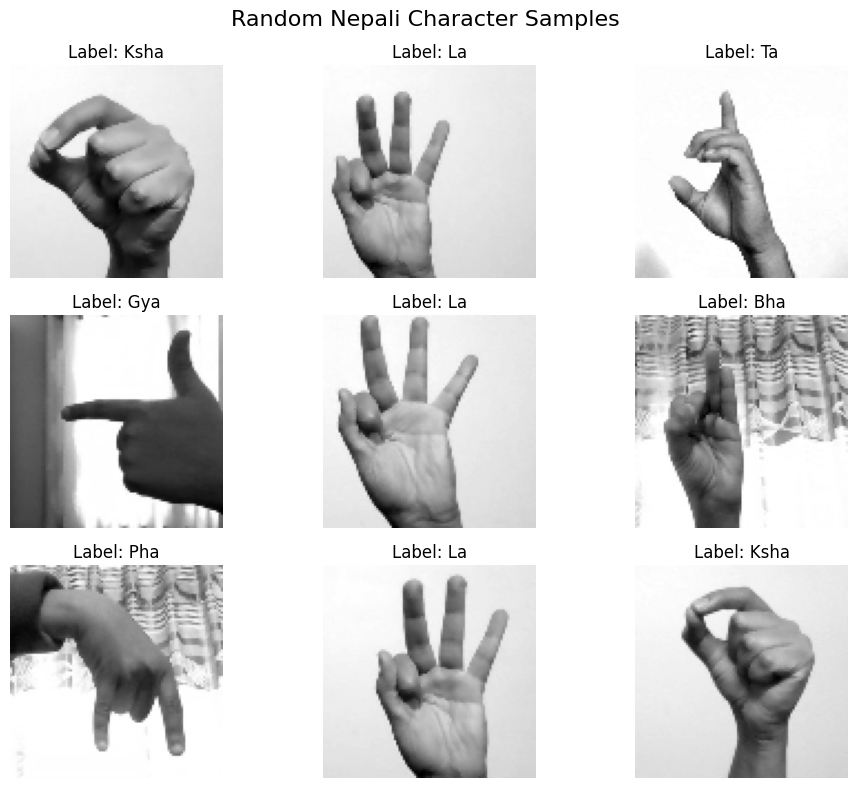

In [13]:
nepali_map_roman = {
    0: 'Ka', 1: 'Kha', 2: 'Ga', 3: 'Gha', 4: 'Nga',
    5: 'Cha', 6: 'Chha', 7: 'Ja', 8: 'Jha', 9: 'Nya',
    10: 'Ta', 11: 'Tha', 12: 'Da', 13: 'Dha', 14: 'Na',
    15: 'Ta', 16: 'Tha', 17: 'Da', 18: 'Dha', 19: 'Na',
    20: 'Pa', 21: 'Pha', 22: 'Ba', 23: 'Bha', 24: 'Ma',
    25: 'Ya', 26: 'Ra', 27: 'La', 28: 'Wa', 29: 'Sha',
    30: 'Sha', 31: 'Sa', 32: 'Ha', 33: 'Ksha', 34: 'Tra', 35: 'Gya'
}

plt.figure(figsize=(10, 8))
for i in range(9):
    idx = random.randint(0, len(X) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[idx].reshape(X[idx].shape[0], X[idx].shape[1]), cmap='gray')
    label_index = np.argmax(y[idx])
    label = nepali_map_roman.get(label_index, f"Label {label_index}")
    plt.title(f"Label: {label}", fontsize=12)
    plt.axis('off')

plt.suptitle("Random Nepali Character Samples ", fontsize=16)
plt.tight_layout()
plt.show()

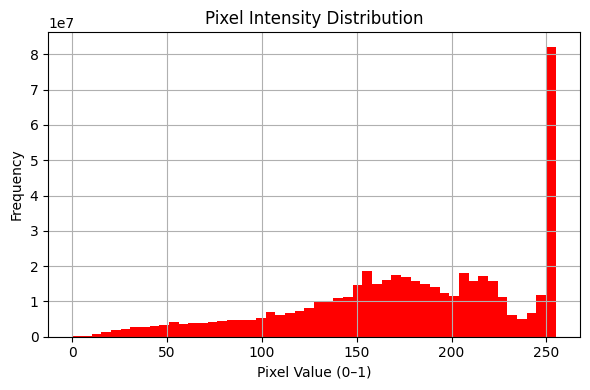

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(X.flatten(), bins=50, color='red')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0–1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [16]:
model = Sequential([
    Input(shape=(96, 96, 1)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  
    MaxPooling2D(2, 2),                     
    Flatten(),
    Dense(256, activation='relu'),         
    Dropout(0.4),                           
    Dense(36, activation='softmax')  
])

2025-08-06 00:59:44.127380: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,378,980 (12.89 MB)

 Trainable params: 3,378,980 (12.89 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 397s 291ms/step - accuracy: 0.5705 - loss: 3.0879 - val_accuracy: 0.9615 - val_loss: 0.1317
Epoch 2/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 400s 296ms/step - accuracy: 0.9367 - loss: 0.2046 - val_accuracy: 0.9716 - val_loss: 0.0971
Epoch 3/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 409s 303ms/step - accuracy: 0.9533 - loss: 0.1528 - val_accuracy: 0.9793 - val_loss: 0.0716
Epoch 4/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 424s 314ms/step - accuracy: 0.9696 - loss: 0.1036 - val_accuracy: 0.9828 - val_loss: 0.0576
Epoch 5/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 404s 299ms/step - accuracy: 0.9697 - loss: 0.0923 - val_accuracy: 0.9764 - val_loss: 0.0774
Epoch 6/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 393s 291ms/step - accuracy: 0.9789 - loss: 0.0662 - val_accuracy: 0.9864 - val_loss: 0.0495
Epoch 7/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 385s 286ms/step - accuracy: 0.9810 - loss: 0.0626 - val_accuracy: 0.9860 - val_loss: 0.0451
Epoch 8/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 389s 288ms/step - ac

In [19]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\n Test Accuracy: {acc*100:.2f}%")

338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.9907 - loss: 0.0378

 Test Accuracy: 99.06%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


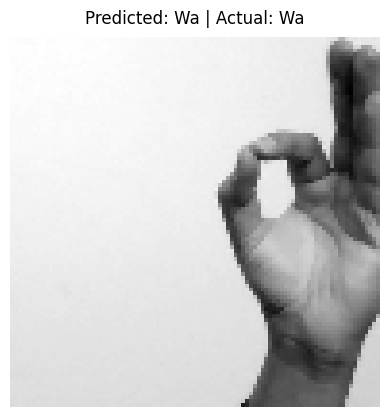

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


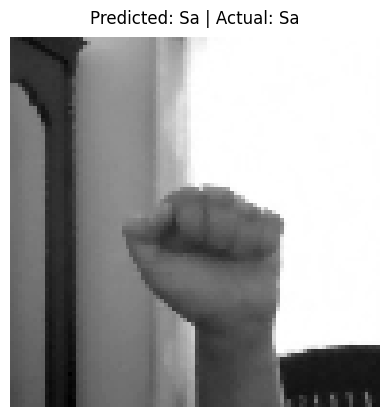

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


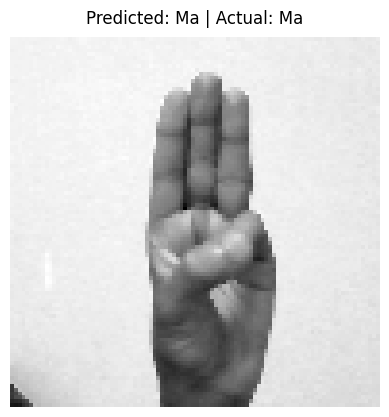

In [20]:
for _ in range(3):
    index = random.randint(0, len(X_test) - 1)
    prediction = model.predict(X_test[index:index+1])
    predicted_class = np.argmax(prediction)
    true_class = np.argmax(y_test[index])

    plt.imshow(X_test[index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Predicted: {nepali_map_roman[predicted_class]} | Actual: {nepali_map_roman[true_class]}", pad=10)
    plt.axis('off')
    plt.show()


In [21]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step


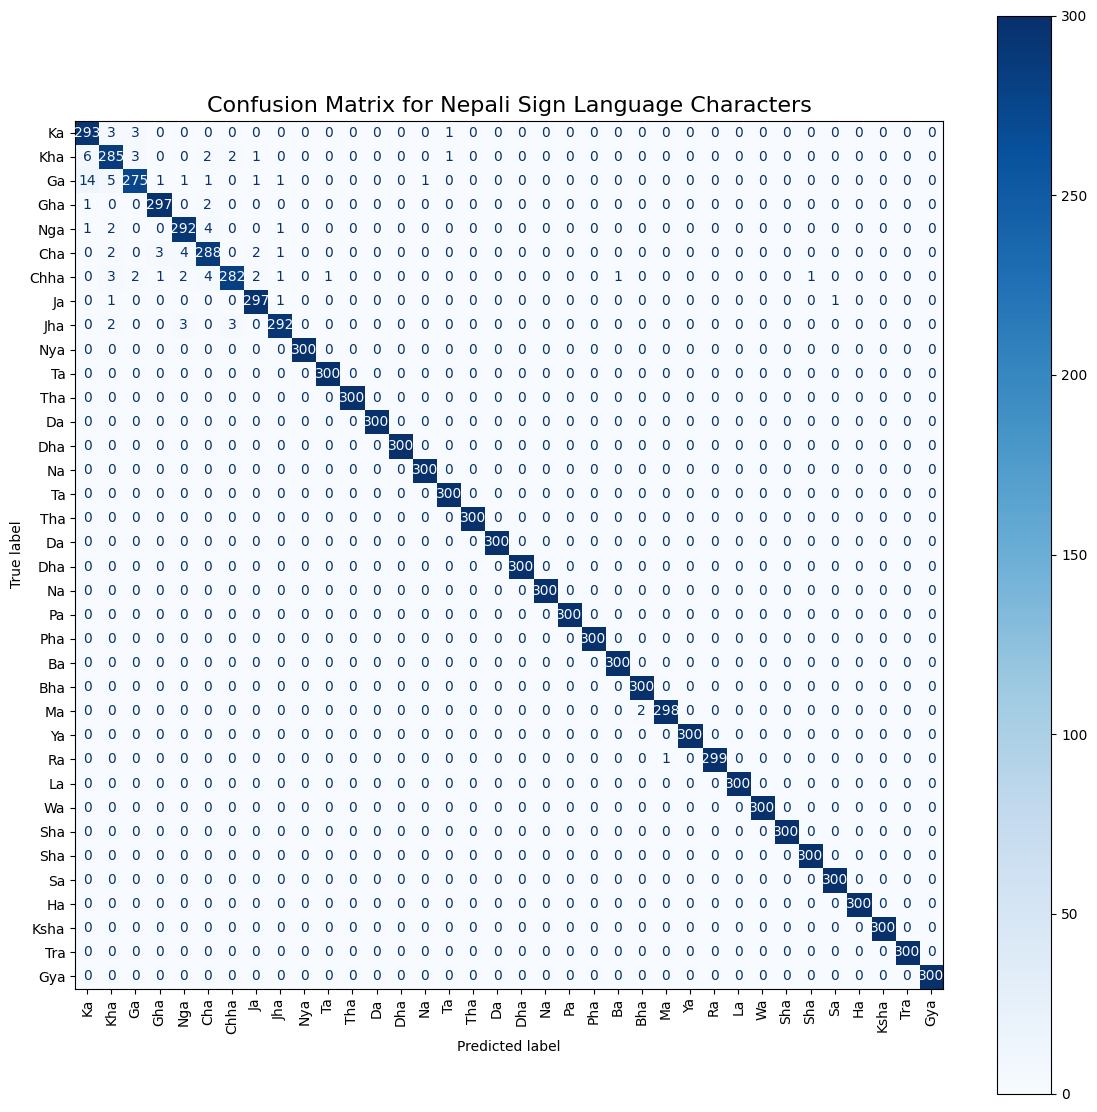

In [22]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[nepali_map_roman[i] for i in range(36)])
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix for Nepali Sign Language Characters", fontsize=16)
plt.show()

In [23]:
report = classification_report(y_true, y_pred, target_names=[nepali_map_roman[i] for i in range(36)])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

          Ka       0.93      0.98      0.95       300
         Kha       0.94      0.95      0.95       300
          Ga       0.97      0.92      0.94       300
         Gha       0.98      0.99      0.99       300
         Nga       0.97      0.97      0.97       300
         Cha       0.96      0.96      0.96       300
        Chha       0.98      0.94      0.96       300
          Ja       0.98      0.99      0.99       300
         Jha       0.98      0.97      0.98       300
         Nya       1.00      1.00      1.00       300
          Ta       1.00      1.00      1.00       300
         Tha       1.00      1.00      1.00       300
          Da       1.00      1.00      1.00       300
         Dha       1.00      1.00      1.00       300
          Na       1.00      1.00      1.00       300
          Ta       0.99      1.00      1.00       300
         Tha       1.00      1.00      1.00       300
   

/tmp/ipykernel_36/1560884301.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


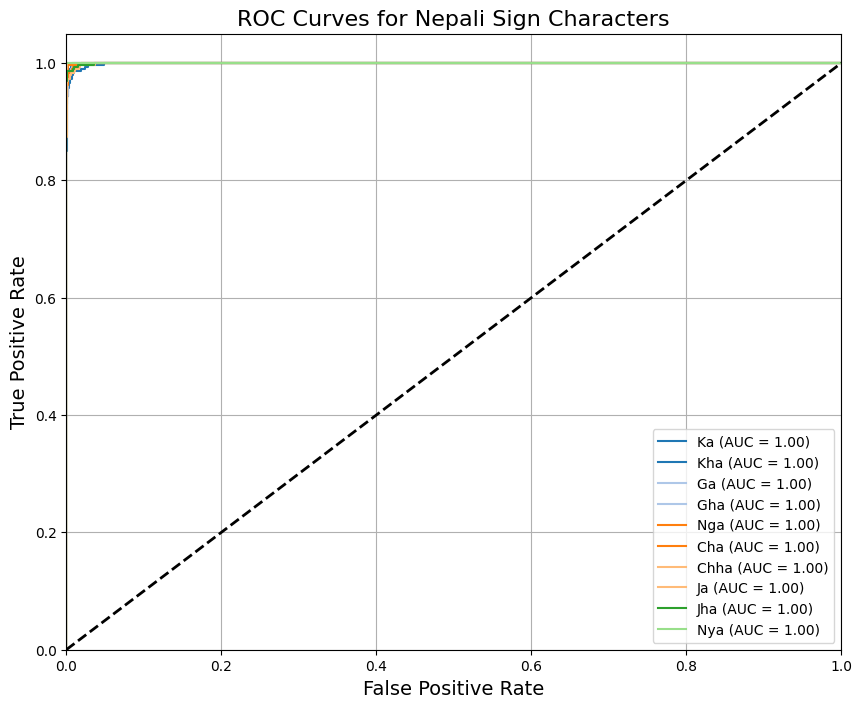

Micro-average ROC AUC: 1.0000
Macro-average ROC AUC: 0.9999


In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ROC-AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for first 10 classes (you can increase if needed)
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', n_classes)

for i in range(10):  # Adjust range if you want more/all
    plt.plot(fpr[i], tpr[i], label=f"{nepali_map_roman[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Nepali Sign Characters', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

# Average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_pred_probs, average='micro')
roc_auc_macro = roc_auc_score(y_test, y_pred_probs, average='macro')
print(f"Micro-average ROC AUC: {roc_auc_micro:.4f}")
print(f"Macro-average ROC AUC: {roc_auc_macro:.4f}")


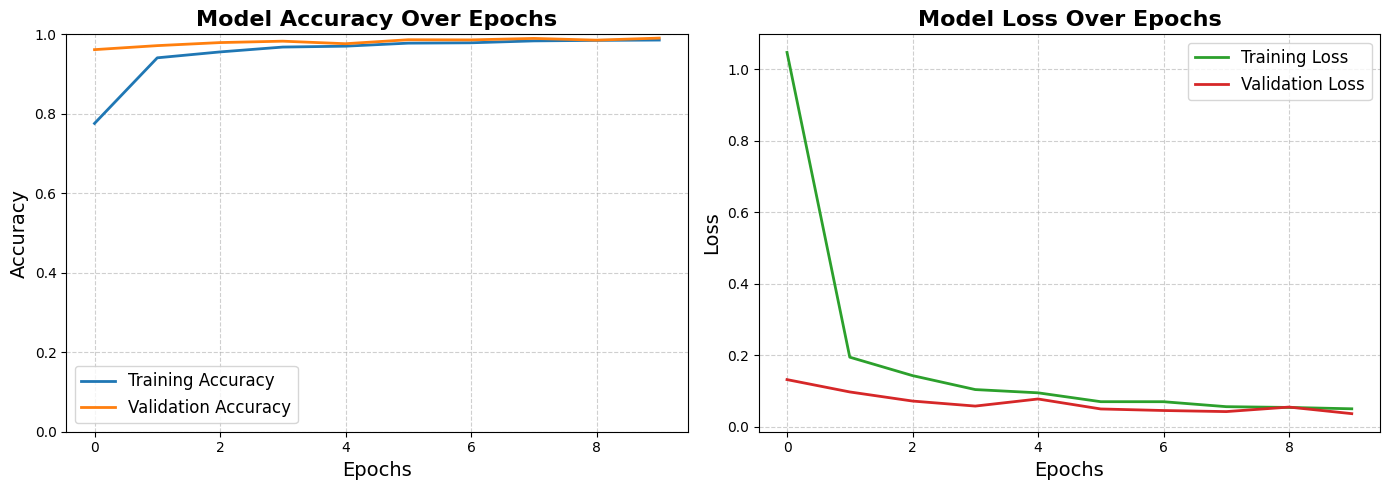

In [25]:
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=2)
plt.title("Model Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#2ca02c', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#d62728', linewidth=2)
plt.title("Model Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [26]:

model.save("/kaggle/working/nepali_sign_language_cnn.h5")


In [27]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [28]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)


In [29]:
print("\n Logistic Regression with PCA")
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

lr_model = LogisticRegression(max_iter=200, n_jobs=-1)
lr_model.fit(X_train_pca, y_train_labels)
lr_preds = lr_model.predict(X_test_pca)
lr_acc = accuracy_score(y_test_labels, lr_preds)
print(f"Logistic Regression Accuracy: {lr_acc*100:.2f}%")




 Logistic Regression with PCA
Logistic Regression Accuracy: 88.64%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
print("\n Random Forest")
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_model.fit(X_train_flat, y_train_labels)
rf_preds = rf_model.predict(X_test_flat)
rf_acc = accuracy_score(y_test_labels, rf_preds)
print(f"Random Forest Accuracy: {rf_acc*100:.2f}%")




 Random Forest
Random Forest Accuracy: 99.44%


In [31]:
print("\n MLP Classifier")
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, solver='adam', random_state=42)
mlp_model.fit(X_train_flat, y_train_labels)
mlp_preds = mlp_model.predict(X_test_flat)
mlp_acc = accuracy_score(y_test_labels, mlp_preds)
print(f"MLP Accuracy: {mlp_acc*100:.2f}%")




 MLP Classifier


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 2.78%


In [32]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

print("\n Linear SVM ")

class_counts = defaultdict(int)
max_per_class = 100
X_svm, y_svm = [], []

for i in range(len(X_train_flat)):
    label = y_train_labels[i]
    if class_counts[label] < max_per_class:
        X_svm.append(X_train_flat[i])
        y_svm.append(label)
        class_counts[label] += 1
X_svm = np.array(X_svm)
y_svm = np.array(y_svm)

X_svm_pca = pca.transform(X_svm)  

scaler = StandardScaler()
X_svm_pca_scaled = scaler.fit_transform(X_svm_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

svm_model = LinearSVC(max_iter=2000, dual=False)
svm_model.fit(X_svm_pca_scaled, y_svm)
svm_preds = svm_model.predict(X_test_pca_scaled)
svm_acc = accuracy_score(y_test_labels, svm_preds)
print(f"Linear SVM Accuracy: {svm_acc*100:.2f}%")





 Linear SVM 
Linear SVM Accuracy: 74.26%


In [54]:


print("\n--- Model Accuracy Comparison ---")
print(f"CNN:        {acc*100:.2f}%")
print(f"LogReg+PCA: {lr_acc*100:.2f}%")
print(f"RandomForest: {rf_acc*100:.2f}%")
print(f"MLP:        {mlp_acc*100:.2f}%")
print(f"SVM:        {svm_acc*100:.2f}%")


--- Model Accuracy Comparison ---
CNN:        99.06%
LogReg+PCA: 88.64%
RandomForest: 99.44%
MLP:        2.78%
SVM:        74.26%


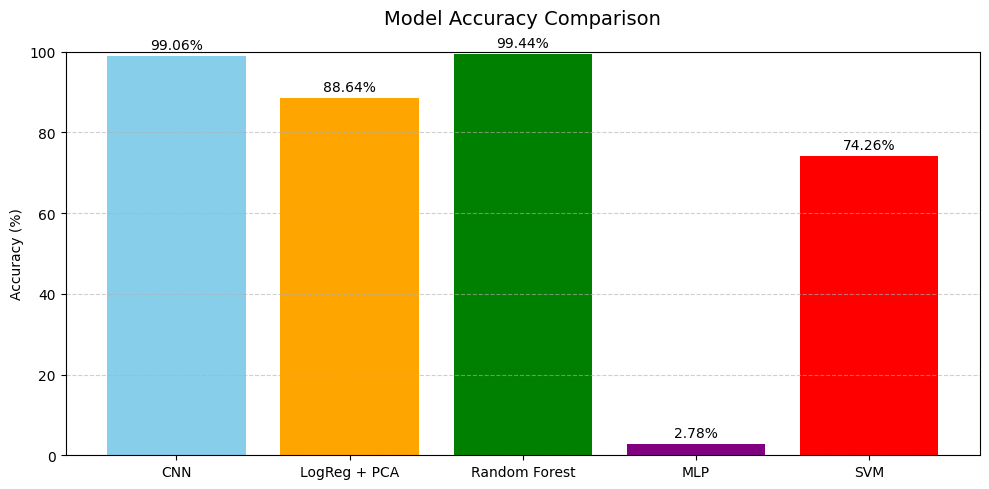

In [55]:
model_names = ['CNN', 'LogReg + PCA', 'Random Forest', 'MLP', 'SVM']
accuracies = [acc * 100, lr_acc * 100, rf_acc * 100, mlp_acc * 100, svm_acc * 100]

plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'purple', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14, pad=20)

plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [56]:
def show_predictions(images, true_labels, pred_labels, model_name):
    indices = random.sample(range(len(images)), 3)
    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f"True: {nepali_map_roman[true_labels[idx]]}\nPred: {nepali_map_roman[pred_labels[idx]]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} - Predictions")
    plt.tight_layout()
    plt.show()

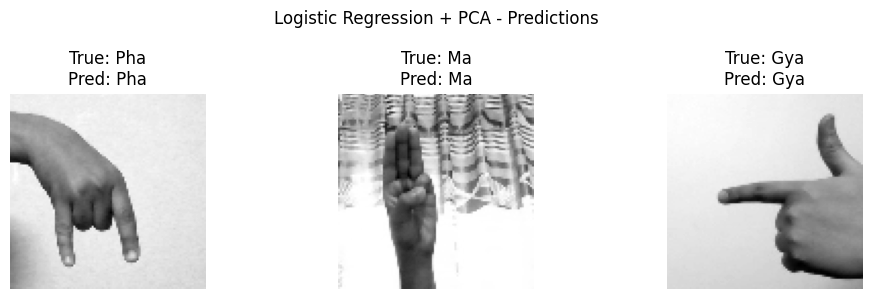

In [57]:
show_predictions(X_test, y_test_labels, lr_preds, "Logistic Regression + PCA")


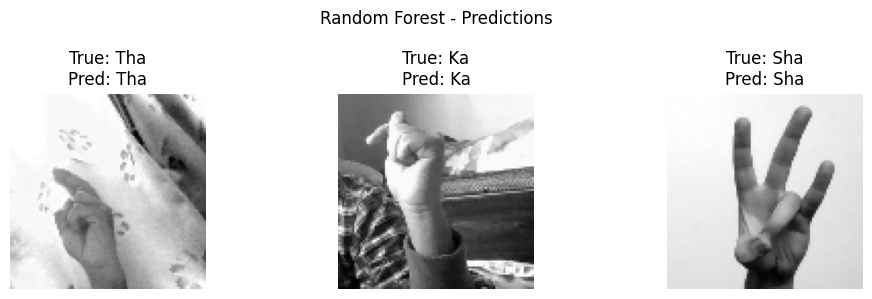

In [58]:
show_predictions(X_test, y_test_labels, rf_preds, "Random Forest")


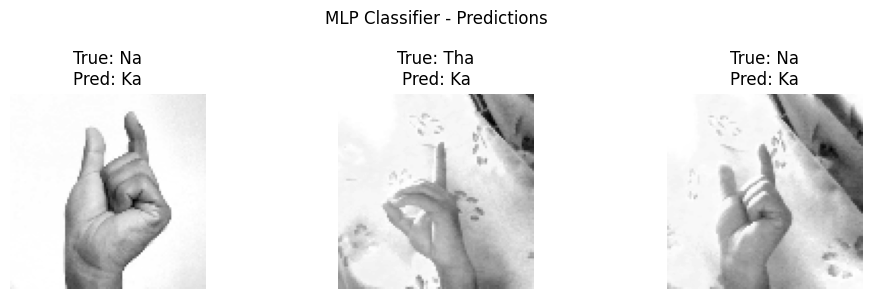

In [59]:
show_predictions(X_test, y_test_labels, mlp_preds, "MLP Classifier")


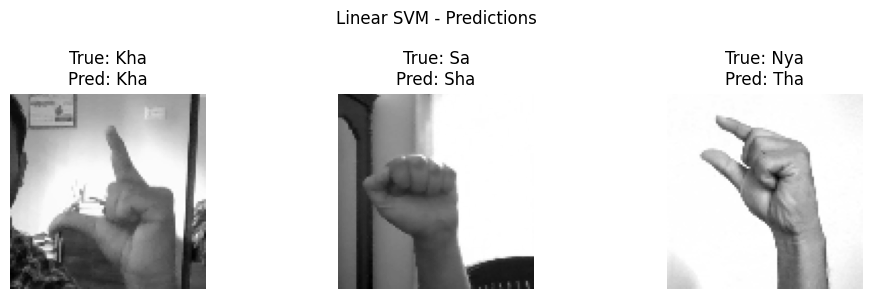

In [60]:
show_predictions(X_test, y_test_labels, svm_preds, "Linear SVM")


338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step


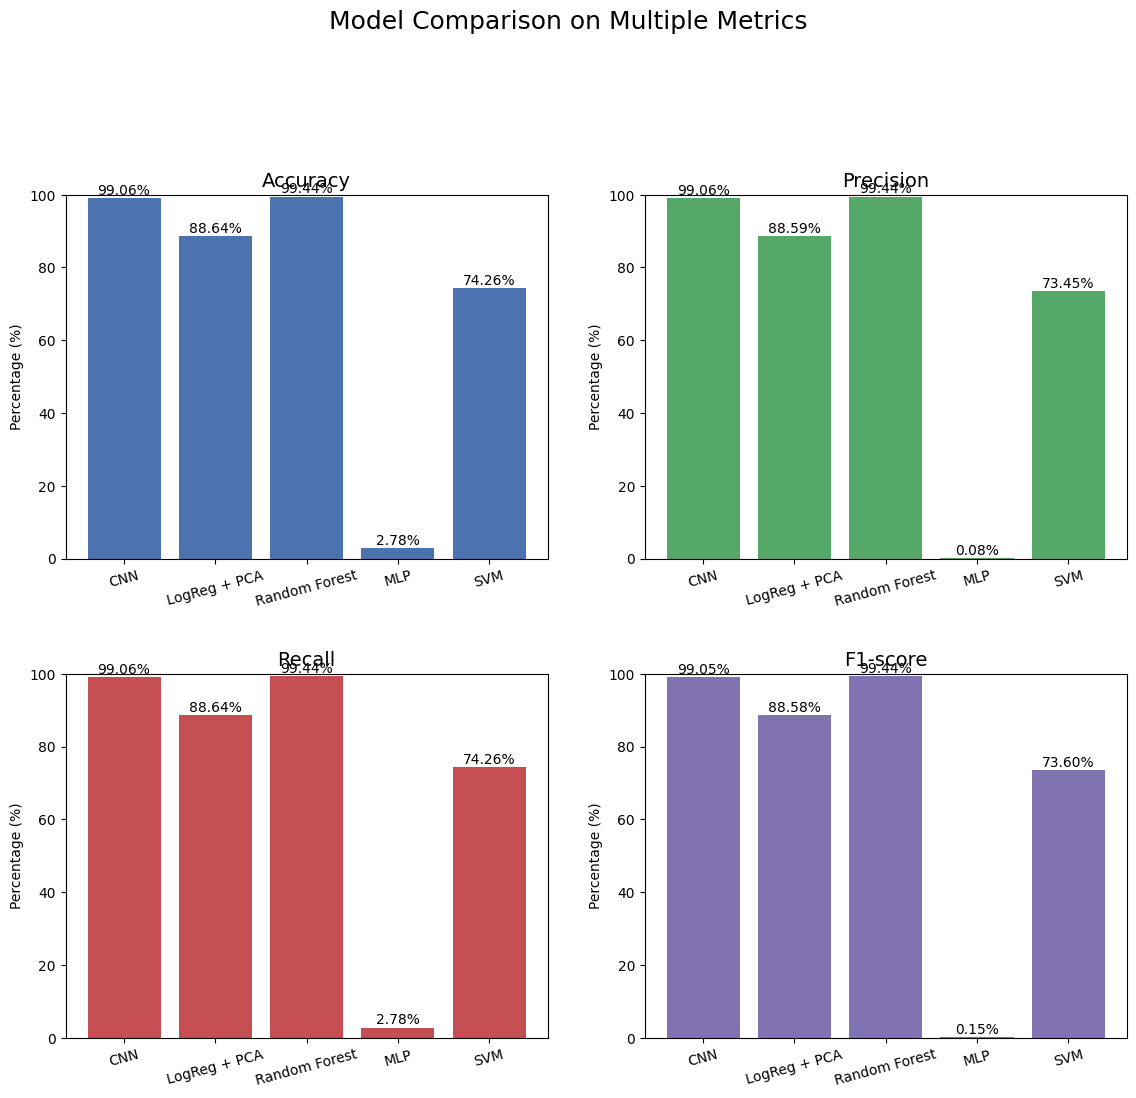

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are predictions and y_test_labels (true labels)
model_names = ["CNN", "LogReg + PCA", "Random Forest", "MLP", "SVM"]
all_preds = [
    np.argmax(model.predict(X_test), axis=1),  # CNN
    lr_preds,
    rf_preds,
    mlp_preds,
    svm_preds
]

# Store results
accuracies = []
precisions = []
recalls = []
f1_scores = []

for preds in all_preds:
    accuracies.append(accuracy_score(y_test_labels, preds))
    precisions.append(precision_score(y_test_labels, preds, average='macro', zero_division=0))
    recalls.append(recall_score(y_test_labels, preds, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_test_labels, preds, average='macro', zero_division=0))

# Create bar plots
metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]
colors = ["#4c72b0", "#55a868", "#c44e52", "#8172b2"]

plt.figure(figsize=(12, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(model_names, np.array(metrics[i])*100, color=colors[i])
    plt.title(metric_names[i], fontsize=14)
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=15)
    for j, v in enumerate(np.array(metrics[i])*100):
        plt.text(j, v + 1, f"{v:.2f}%", ha='center', fontsize=10)

plt.tight_layout(pad=3)
plt.suptitle("Model Comparison on Multiple Metrics", fontsize=18, y=1.12)  # Increased y-value for spacing
plt.show()


In [53]:
print("hello world")

hello world
